# TP: Introduction to RNN

## BPTT vs. Truncated BPTT

### BPTT

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Parameters
mu = 1
theta = torch.tensor(1.0, requires_grad=True)  # Initial value for theta
T = 20  # Number of time steps
m_b = 1024  # Number of samples

x0_samples = torch.normal(mu, 1, size=(m_b, 1), device=device)

# Define the dynamics function
def f(x, theta):
    return x + theta

# Define the loss function
def loss(x_t, theta, target=mu, T=T):
    Lt = torch.zeros(1).to(device)
    for _ in range(T):
        Lt += torch.mean((x_t - target)**2)
        x_t = f(x_t, theta)
    return Lt

In [4]:
# Compute the gradient of the loss function
def compute_gradient(x0_samples, theta):
    x_t = x0_samples
    Lt = loss(x_t, theta)
    Lt.backward()
    return theta.grad

print('Gradient:', compute_gradient(x0_samples, theta))

Gradient: tensor(4914.0786)


In [5]:
# Gradient descent
def gradient_descent(theta, x0_samples, loss_fn, lr=0.1, n_iter=100):
    losses = []
    gradients = []
    
    # Optimizer
    if callable(lr):
        optimizer = optim.SGD([theta], lr=lr(0))
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)
    else:
        optimizer = optim.SGD([theta], lr=lr)
        scheduler = None
    
    for iteration in range(n_iter):
        # Zero the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Compute the loss and the gradient
        Lt = loss_fn(x0_samples, theta)
        Lt.backward()
        
        # Update the parameter
        optimizer.step()
        
        # Update the learning rate if scheduler is used
        if scheduler:
            scheduler.step()
        
        # Store the loss and the gradient
        losses.append(Lt.item())
        gradients.append(theta.grad.item())
        
        # Print the loss and theta for monitoring
        if (iteration + 1) % (n_iter // 10) == 0:
            print(f"Iteration {iteration + 1}: Loss = {Lt.item()}, Theta = {theta.item()}")
        
    return losses, gradients

Iteration 10: Loss = 20.604955673217773, Theta = 0.006341672036796808
Iteration 20: Loss = 20.59339141845703, Theta = 0.005248368252068758
Iteration 30: Loss = 20.5933895111084, Theta = 0.00524717615917325
Iteration 40: Loss = 20.5933895111084, Theta = 0.005247166380286217
Iteration 50: Loss = 20.5933895111084, Theta = 0.00524717615917325
Iteration 60: Loss = 20.5933895111084, Theta = 0.005247166380286217
Iteration 70: Loss = 20.5933895111084, Theta = 0.00524717615917325
Iteration 80: Loss = 20.5933895111084, Theta = 0.005247166380286217
Iteration 90: Loss = 20.5933895111084, Theta = 0.00524717615917325
Iteration 100: Loss = 20.5933895111084, Theta = 0.005247166380286217


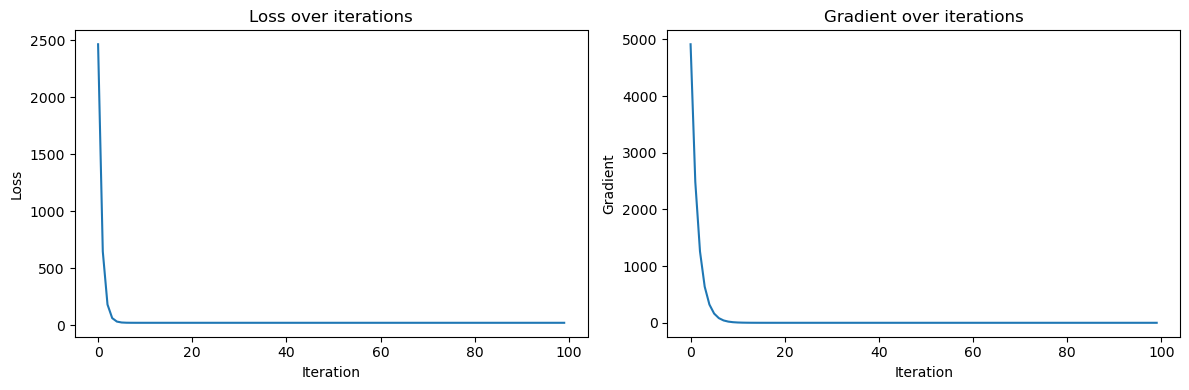

In [6]:
# Run the gradient descent
theta = torch.tensor(1.0, requires_grad=True)
losses, gradients = gradient_descent(theta, x0_samples, loss_fn=loss, lr=1e-4, n_iter=100)

# Plot the losses and the gradients
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(gradients)
plt.title('Gradient over iterations')
plt.xlabel('Iteration')
plt.ylabel('Gradient')

plt.tight_layout()
plt.show()

### Truncated BPTT

In [9]:
def truncated_loss(x_t, theta, target=mu):
    x_t = f(x_t.detach(), theta)
    return torch.mean((x_t - target)**2).to(device)

Iteration 100: Loss = 1.0784457921981812, Theta = 0.29177215695381165
Iteration 200: Loss = 1.0755836963653564, Theta = 0.2853531539440155
Iteration 300: Loss = 1.074371337890625, Theta = 0.28256189823150635
Iteration 400: Loss = 1.0736644268035889, Theta = 0.2809138596057892
Iteration 500: Loss = 1.0731885433197021, Theta = 0.27979594469070435
Iteration 600: Loss = 1.0728404521942139, Theta = 0.2789742052555084
Iteration 700: Loss = 1.0725717544555664, Theta = 0.2783375680446625
Iteration 800: Loss = 1.0723564624786377, Theta = 0.2778257727622986
Iteration 900: Loss = 1.0721790790557861, Theta = 0.2774026393890381
Iteration 1000: Loss = 1.0720295906066895, Theta = 0.27704545855522156


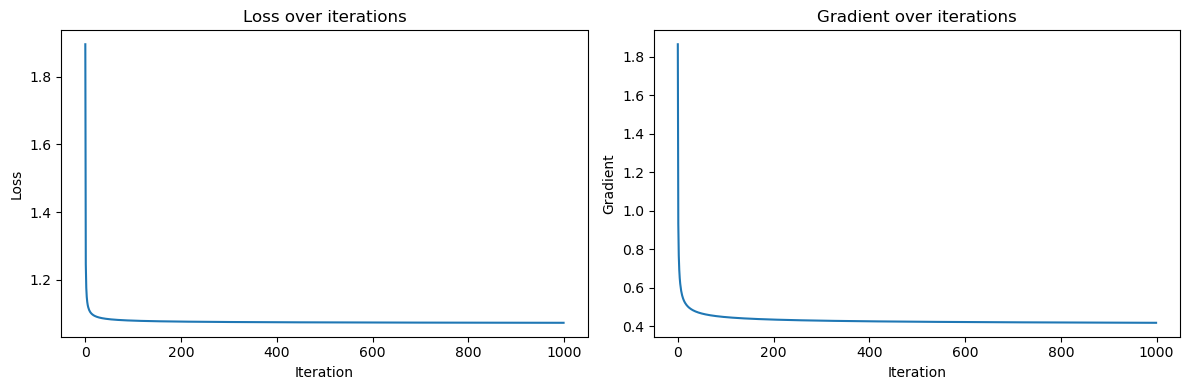

In [12]:
# Run the gradient descent
theta = torch.tensor(1.0, requires_grad=True)
lr = 1e-4
lr = lambda epoch: 0.5 / (epoch + 1)
lr = lambda epoch: 0.5 / (epoch + 1) ** (3 / 2)

losses, gradients = gradient_descent(theta, x0_samples, loss_fn=truncated_loss, lr=lr, n_iter=1000)

# Plot the losses and the gradients
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(gradients)
plt.title('Gradient over iterations')
plt.xlabel('Iteration')
plt.ylabel('Gradient')

plt.tight_layout()
plt.show()